In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# How to  generate new data using Generative Adversarial Networks
# in a differential private mode 

   
#   
#### ***by Lyudmyla Dymytrova, Lorenzo Frigerio, and Anderson Santana de Oliveira***
August 2019

###    
## Introduction

   This tutorial shows how to generate a new (fake) dataset using Generative Adversarial Network as reported in  Frigerio L., Santana de Oliveira A., Gomez L. & Duverger P. (2019) Differentially private GANs for time series, continuous and discrete Open Data) (http://arxiv.org/abs/1901.02477). With the exception that we use out of the box, AutoML classifier for checking the quality of the generated data. 

In [2]:
# Load modules
import os, sys


import random
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import csv
import time
import pickle 

import tflib as lib
import tflib.ops.linear
import tflib.plot
import tflib.inception_score

from differential_privacy.dp_sgd.dp_optimizer import dp_optimizer
from differential_privacy.dp_sgd.dp_optimizer import sanitizer
from differential_privacy.privacy_accountant.tf import accountant

from discretedata_manager import discretedata_manager
from models import Generator, Discriminator

from scipy.stats import wasserstein_distance, chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score

W0816 14:43:42.869918 35388 deprecation_wrapper.py:119] From C:\Users\i061767\GitHub\testbed\differential_privacy\dp_sgd\dp_optimizer\dp_optimizer.py:27: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.



In [3]:
# Initialize H2O.api for AutoML 
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.212-b10, mixed mode)
  Starting server from C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\i061767\AppData\Local\Temp\tmpiw_hh7mr
  JVM stdout: C:\Users\i061767\AppData\Local\Temp\tmpiw_hh7mr\h2o_i061767_started_from_python.out
  JVM stderr: C:\Users\i061767\AppData\Local\Temp\tmpiw_hh7mr\h2o_i061767_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,06 secs
H2O cluster timezone:,Europe/Paris
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.3
H2O cluster version age:,3 months and 9 days !!!
H2O cluster name:,H2O_from_python_i061767_iqxtb0
H2O cluster total nodes:,1
H2O cluster free memory:,3.521 Gb
H2O cluster total cores:,0
H2O cluster allowed cores:,0
H2O cluster status:,"accepting new members, healthy"


In [4]:

# Load dataset for training
adult = pd.read_csv("./dataset/adult.csv",delimiter=',',
                    skipinitialspace = True)
adult.head()


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,output
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,Fal
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,Fal
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,Fal
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,Fal
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,Fal


### Data preprocessing

The first step is a preparation of data to a specific format for training WGAN. The input data set must be in a format of Pandas DataFrame. Data can be labelled or unlabeled. 
- **Missing values** is an issue only for classifier and do not impact the WGAN itself, so the next step might be skipped for unlabeled data. If dataset contains missing values, by default columns with more than 50% of NaN will be removed. The number of permitted missing values in a column can be reduced by user (an argument na_percent). If the number of permitted missing values in a column is less than a given threshold, each missing value will be replaced by a string that combines ‘missing’ and the column name where this missing value occurs. This procedure allows to distinguish between NaN values that occur in different columns. 
- So far only **categorical** features are implemented (the algorithm automatically removes all numerical features except a target column). If data labelled, a target column must be binary due to H2O AutoML does not have implemented multilabel classification yet??? A **target column** can be categorical (with two levels) or numerical. 
- The algorithm performs a random subsampling of majority class if data are **imbalanced**. Within the preprocessing step a function ‘prepare_data’ performs a random shuffling and **splitting data** into test (33% of data) and train (67%) datasets preserving a class balance for the target column in both datasets.  
- There is no train/test split for an **unlabelled** data. The entire input dataset is used for WGAN training.
- **The output** contains 4 instances, i.e. train_data (data frame), test_data (data frame), variables (list of strings) and target (string) that are used at next steps to train WGAN.

```adult = pd.read_csv("./dataset/adult.csv", delimiter=',',  skipinitialspace = True)
prepData = prepare_data(adult, target='output')
prepData.test_data.shape
prepData.target
prepData.variables```

In [5]:
# Data preprocessing with train/test splitting 

class prepare_data(object):
    def __init__(self, data, target = None, na_percent = 0.5):
        self.data = data
        self.target = target
        self.na_percent = na_percent
        self.train_data, self.test_data, self.variables  = self.prepare_discrete_data()
 
    def prepare_discrete_data(self):
        TextData = self.data.select_dtypes(include = ['object']).copy()
        discrete_cols = TextData.columns
        NewData = TextData[discrete_cols]
        # Check if there are NaN values 
        if NewData.isnull().values.any() == True:
            # Remove columns with more than xx% of NaN (xx% is user-defined or 0.5 by default)
            NewData.dropna(thresh = NewData.shape[0]*(1-self.na_percent), how ='all', axis = 1, inplace = True)
            # In rest of columns replace NaN by a string 'missing_column_name'
            for col, name in enumerate(NewData.columns):
                values = {name: str("missing "+ NewData.columns[col])}
                NewData.fillna(value = values, inplace = True)
        # If data is unlabelled, no preprocessing
        if self.target == None:
            train_data = NewData
            test_data = pd.DataFrame()
            print('WARNING: no test data for unlabelled dataset')
            return train_data, test_data, discrete_cols
        else:
            # If data is labelled, check a format of the target variable
            if self.data[self.target].dtype != object:
                NewData = pd.concat((TextData, self.data[self.target]), axis = 1)
                discrete_cols = NewData.columns
            pos = NewData.loc[NewData[self.target] == NewData[self.target].unique()[0]]
            neg = NewData.loc[NewData[self.target] == NewData[self.target].unique()[1]]
            # Check if classes are balanced
            if len(pos) == len(neg):
                train_data, test_data = train_test_split(NewData, test_size = 0.33, random_state = 1, shuffle = True,
                                                             stratify = NewData[self.target])
                return train_data, test_data, discrete_cols
            # If classes are unbalanced, randomly subsample majority class
            elif len(pos) < len(neg):
                neg = neg.sample(len(pos))
                data = pd.concat((pos,neg),axis=0)
                train_data, test_data = train_test_split(data, test_size = 0.33, random_state = 1, shuffle = True,
                                                             stratify = data[self.target])
                return train_data, test_data, discrete_cols
            else:
                pos = pos.sample(len(neg))
                data = pd.concat((pos,neg),axis=0)
                train_data, test_data = train_test_split(data, test_size = 0.33, random_state = 1, shuffle = True,
                                                             stratify = data[self.target])
                return train_data, test_data, discrete_cols

In [6]:
# ADULT DATASET:  Data preprocessing
adult_pr = prepare_data(adult, target='output')
adult_pr.test_data.shape

(5176, 9)

In [7]:
adult_pr.train_data.output.value_counts()

Tru    5253
Fal    5253
Name: output, dtype: int64

### Tuning WGAN hyperparameters

The next important step is a choice of hyperparameters for training WGAN. This can be done at one step using a function ‘WGAN_params’. 
- **privacy**: boolean, True or False. The user can choose to train WGAN in a differential private or public mode. 
- **batch_size**: the number of samples n that are processed by WGAN at once. The generator generates n fake samples (batch) that are further compared by discriminator to a randomly sampled n samples (batch) of real training data. After processing a batch, generator parameters are updating, and a new set of n samples (batch) are generated. 
- **complexity**: the shape of output arrays produced by each layers of Neural Network models in Generator and Discriminator. The exception are the last layers in both NN models that produce one-dimensional array in case of Discriminator and m-dimensional array for Generator with m equal to the number of rows in train data. This parameter defines the complexity of Neural Network models.
- **mode**: WGAN algorithm can be performed in a standard way (‘wgan’) or using a gradient penalty clipping (‘wgan-gp’) introduced by Gulrajani et al. (2017).
- **gradient_coeff**: a gradient penalty coefficient that was experimentally tested by Gulrajani et al. (2017) on a variety of NN architectures and datasets. The default value is 10. According to Frigerio L. smaller values of a gradient penalty coefficient increase a speed of training for small datasets but can be compensated by increasing the number of disc_iters instead.
- **norm_bound**: L2 norm that is used to clip a gradient of Discriminator. For more details see Abadi et al. (2016).
- **learning_rate**: learning rate of the differential private Stochastic Gradient Descent optimizer (dp-SGD) for Discriminator. The default value is 0.001. The learning rate of the Adam optimizer for Generator is not a parameter (but can be implemented if necessary) and by default equal to 0.0001.
- **noise**: a noise level that corresponds to a variance of the gaussian noise added to the gradient (dp-SGD) of Discriminator optimizer to achieve differential privacy. This parameter has a direct impact on privacy budget: the higher a noise level, the smaller value of epsilon.
- **gen_iters**: the number of Generator iterations to produce one batch of fake samples. Critic_gen in Lorenzo’s version.
- **disc_iters**: the number of Discriminator iterations performed by one iteration of Generator and using only one batch of samples.
- **target_delta**: differential privacy parameter that defines the probability at which a certain level of privacy (epsilon) is correct. At each generator run the algorithm returns epsilon value. If target_delta is None, it is calculated as following:  1/(number of rows in train data ). The user-defined target_epsilon can be easily implemented if necessary.
- **stop_criterion**: the differential privacy budget (epsilon, by default 32). In a differential private mode of WGAN the training is stopped as far as the epsilon value of generated data is higher than a given stopping criterion. If the stopping criterion is assigned to +Inf or WGAN is trained in a public mode, the algorithm will stop after 1000 iterations (epochs). 
- **interval**: a period with which the WGAN outputs and accuracies of Classifiers (scores and plots) are saved.

Use print(my_params.__dict__) to see the default values: 

```my_params = WGAN_params(noise = 3.0, target_delta = 0.00001)
print(my_params.__dict__)```

In [8]:
class WGAN_params(object):
    def __init__(self, batch_size = 256, complexity = 512, mode = 'wgan-gp',
                 gradient_coeff = 10, norm_bound = 0.2, learning_rate = 1e-3, noise = 7.0,
                 gen_iters = 1, disc_iters = 5, target_delta = None, stop_criterion = 32, interval = 20):
        self.batch_size = batch_size
        self.complexity = complexity
        self.mode = mode
        self.gradient_coeff = gradient_coeff
        self.norm_bound = norm_bound
        self.learning_rate = learning_rate
        self.noise = noise
        self.gen_iters = gen_iters
        self.disc_iters = disc_iters
        self.target_delta = target_delta
        self.stop_criterion = stop_criterion
        self.interval = interval


In [9]:
# Set WGAN hyperparameters
my_params = WGAN_params(interval = 2)
print(my_params.__dict__)

{'batch_size': 256, 'complexity': 512, 'mode': 'wgan-gp', 'gradient_coeff': 10, 'norm_bound': 0.2, 'learning_rate': 0.001, 'noise': 7.0, 'gen_iters': 1, 'disc_iters': 5, 'target_delta': None, 'stop_criterion': 32, 'interval': 2}


In [10]:
   
# Save Cramer_V statistic for association between the same categorical features in generated (fake) vs. input (real) data
# A score for each epoch

def save_CramerV(list, epoch):
    path = './correlation'
    if os.path.isdir (path) == False:
        os.makedirs(path)
    else:
        pass
    with open(path + "/CramerV_"+ str(epoch)+'.txt','w') as thefile:
        for item in list:
            thefile.write("%s\n" % item)
            
# Save the matrix of correlations between different features
# Two correlation matrices side by side are returned, i.e. for real and generated data
# A matrix for each epoch
# WARNING: data should not contain missing values

def saveCorrelationMatrix(real, fake, epoch):
    path = './correlation'
    if os.path.isdir (path) == False:
        os.makedirs(path)
    else:
        pass
    real = pd.get_dummies(real).corr(method = 'pearson')
    fake = pd.get_dummies(fake).corr(method = 'pearson')
    fig, axs = plt.subplots(figsize = (15,7), ncols=2)
    sns.heatmap(real, yticklabels = False, ax = axs[0])
    axs[0].set_title('Real data')
    sns.heatmap(fake, yticklabels = False, ax = axs[1])
    axs[1].set_title('Generated data')
    fig.savefig(path +"/CorrelationMatrix_"+ str(epoch) +".png")
    plt.close(fig)

def getOccurencies(discManager,data):
    lengths = discManager.getLabelsLength()
    totIndex = 0
    columnsValues = discManager.OHdataset.columns.tolist()
    Freq = []
    Name = []
    for index, length in enumerate(lengths):
        Freq_per_Category = []
        Name_Category = []
        if(length > 1):
            samplesDisc = np.argmax(data[:, totIndex:totIndex + length], axis=1)
            for i in range(length):
                Freq_per_Category.append((samplesDisc == i).sum())
                Name_Category.append(columnsValues[i + totIndex])
        Freq += Freq_per_Category
        Name += Name_Category
        totIndex += length
    FreqData = pd.concat([pd.Series(Name), pd.Series(Freq)], axis = 1)
    FreqData.columns = ['Category','Occurrency']
    return FreqData

A function ‘train_WGAN’ requires only two arguments: preprocessed data and a dictionary with hyperparameters of WGAN that are set at the previous step. The algorithm will create automatically a directory (using a given path) where all outputs with a given interval (by default every 20 iterations) will be stored.

```train_WGAN(pat, my_params, './dp-WGAN-discrete_patient_occurencies')```


![alt text](./figs/image003.png "Title")

#### Accuracy of AutoML classifier for labeled data

If data labelled, AutoML Classifier (H2O.ai) is used to evaluate the quality of differential private data generated by WGAN. There is no implementation for unlabeled data yet. The quality of differential private data generated by WGAN is evaluated following Shmelkov et al. (2018): An important characteristic of GAN model is that generated data should not only be realistic, but also recognizable as coming from a given class. An optimal GAN that perfectly captures the target distribution can generate a new set of data (x_fake), which are indistinguishable from the original real training set (x_train). Assuming both these sets have the same size, a classiﬁer trained on either of them should produce roughly the same validation accuracy.
A figure is based on Shmelkov et al. (2018):

![alt text](./figs/image006.jpg "Title")

- **acc_train** is the accuracy of a classiﬁer trained on fake data (x_fake) and tested on a real test data (x_test). When a GAN is not perfect, acc_train will be lower than acc_valid. When acc_train is close to validation accuracy, it means that generated fake data are high quality and as diverse as the training set. acc_train is a measure of the diversity of a GAN, similar to recall, measuring the fraction of real data covered by a GAN.
- **acc_test** is the accuracy of a classiﬁer trained on the original train data but tested on fake (generated) data. Ideally, acc_test should be close to the validation accuracy. If it signiﬁcantly higher, it means that the GAN overﬁts, and simply memorizes the training set. On the contrary, if it is signiﬁcantly lower, the GAN does not capture the target distribution well and the data quality is poor. Note that this measure does not capture the diversity of samples. acc_test accuracy is related to the precision score, quantifying how close generated data are to real data.
- **acc_valid** is the typical validation accuracy of the classiﬁer trained on real train data (x_train) and validated on real test data (x_test).

References:
1.	Martin Abadi, Andy Chu, Ian Goodfellow, H. Brendan McMahan, Ilya Mironov, Kunal Talwar, and Li Zhang. 2016. Deep Learning with Differential Privacy. In Proceedings of the 2016 ACM SIGSAC Conference on Computer and Communications Security (CCS '16). ACM, New York, NY, USA, 308-318. DOI: https://doi.org/10.1145/2976749.2978318.
2.	Ishaan Gulrajani, Faruk Ahmed, Martin Arjovsky, Vincent Dumoulin, and Aaron Courville. 2017. Improved training of wasserstein GANs. In Proceedings of the 31st International Conference on Neural Information Processing Systems (NIPS'17), Ulrike von Luxburg, Isabelle Guyon, Samy Bengio, Hanna Wallach, and Rob Fergus (Eds.). Curran Associates Inc., USA, 5769-5779.
3.	Konstantin Shmelkov, Cordelia Schmid, and Karteek Alahari. 2018. How good is my GAN? In Proceedings of European Conference on Computer Vision.

In [ ]:
# input_data is an output of prepare_data, params is paramters for WGAN training, 
# path is a string to distinguish different datasets (will be used to create a directiry name)

def train_WGAN(input_data, params, path):
    
    # To show the execution time of WGAN
    start_time = time.time()
    
    # Define number of the training iteration 
    epoch = 1000
    
    # Define training data
    data = input_data.train_data
    # One hot encoder of the input dataset
    discManager = discretedata_manager(data)
    
    # Create a directory to store results
    path = path
    if os.path.isdir(path) == False:
        os.makedirs(path)  
    else:
        pass
    print('Outputs will be saved to:'+ str(path))
    
    # Define target delta if it is not given
    if params.target_delta is None:
        target_delta = 1/data.shape[0]
    else: target_delta = params.target_delta
    
    # Build the improved WGAN architecture [Gulrajani et al. 2017]
    diminput = discManager.getLabelLengthTot()
    real_data = tf.placeholder(tf.float32, shape = [None, diminput])
    fake_data = Generator(params.batch_size, real_data, discManager, diminput, params.complexity) 
    disc_real = Discriminator(real_data, diminput, params.complexity)
    disc_fake = Discriminator(fake_data, diminput, params.complexity)
    
    # WGAN loss functions for Discriminator and Generator
    disc_cost = tf.reduce_mean(disc_fake) - tf.reduce_mean(disc_real) 
    gen_cost = -tf.reduce_mean(disc_fake)
    
    # WGAN gradient penalty
    if params.mode == 'wgan-gp':
        alpha = tf.random_uniform(shape = [params.batch_size,1], minval=0.,maxval=1.) 
        interpolates = alpha*real_data + ((1-alpha)*fake_data)
        disc_interpolates = Discriminator(interpolates, diminput, params.complexity)
        gradients = tf.gradients(disc_interpolates, [interpolates])[0]
        slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]))
        gradient_penalty = tf.reduce_mean((slopes-1)**2)
        disc_cost += params.gradient_coeff*gradient_penalty

    disc_params = lib.params_with_name('Discriminator')
    gen_params = lib.params_with_name('Generator')

    # Hyperparameters of the differential privacy for WGAN
    if params.mode == 'wgan-gp':
        eps = tf.placeholder(tf.float32)
        delta = tf.placeholder(tf.float32)
        
        priv_accountant = accountant.GaussianMomentsAccountant(len(input_data.train_data))
    
        clip = True
        iteration_decay = tf.placeholder(tf.float32)
        l2norm_bound = params.norm_bound  
        batches_per_lot = 1
        gaussian_sanitizer = sanitizer.AmortizedGaussianSanitizer(priv_accountant, 
                                                                  [tf.multiply(l2norm_bound,iteration_decay), clip], 
                                                                  disc_params)
        iterationW = tf.placeholder(tf.float32)
        tf.summary.scalar("iter", iterationW)
    
        # Optimizer of the Discriminator (dp-SGD) using differential privacy 
        disc_train_op, sanitized_grads, clipped_grads, not_sanitized_grads, bound, a  = dp_optimizer.DPGradientDescentOptimizer(
            params.learning_rate, 
            [eps, delta], 
            sanitizer = gaussian_sanitizer, 
            sigma = tf.multiply(params.noise,iteration_decay),
            batches_per_lot = batches_per_lot).minimize(disc_cost, iteration = iterationW, var_list = disc_params)
    
#         # Optimizer of the Discriminatort (SGD) without differential privacy
#         disc_train_opSGD = tf.train.GradientDescentOptimizer(params.learning_rate).minimize(disc_cost,var_list=disc_params)
        
#         # Optimizer of the plain GAN with ADAM
#         disc_train_opPublic = tf.train.AdamOptimizer(params.learning_rate, beta1=0.5, beta2=0.9).minimize(disc_cost,
#                                                                                                           var_list=disc_params)
    
        # Optimizer of the Generator (ADAM)
        if len(gen_params) > 0:
            gen_train_op = tf.train.AdamOptimizer(learning_rate=1e-4, beta1 = 0.5, beta2 = 0.9).minimize(gen_cost,
                                                                                                         var_list = gen_params)
        else:
            gen_train_op = tf.no_op()
            
    # Print parameters of the generator and the discriminator
    print ("Generator params:")
    for var in lib.params_with_name('Generator'):
        print ("\t{}\t{}".format(var.name, var.get_shape()))
    print ("Discriminator params:")
    for var in lib.params_with_name('Discriminator'):
        print ("\t{}\t{}".format(var.name, var.get_shape()))
    
    # Generate new (fake) data
    # Calculate occurrencies of categoies for each feature in a generated data
    # Compute the Wasserstein distance on the marginal distibution of the features
    
    def generate_samples(true_dist, discManager, epoch):
        samples = np.concatenate([session.run(fake_data) for _ in range(int(true_dist.shape[0] / int(fake_data.shape[0])))])
        discreteSamples, discreteTextDataset = discManager.convertDiscreteMatrix(samples)
        FreqTable = getOccurencies(discManager, discreteSamples)
        was = 0
        for i in range(samples.shape[1]):
            was += wasserstein_distance(samples[:, i], true_dist[:, i])
        was /= samples.shape[1]
        print("Wasserstein distance: " + str(round(was, 4)))
        return discreteTextDataset, FreqTable, was

    # Compute and display privacy values (delta, epsilon) achieved by dp-WGAN
    def plotPrivacyMeasures(session):
        spent_deltas_eps = priv_accountant.get_privacy_spent(session, target_deltas = [target_delta])
        for (spent_eps, spent_delta) in spent_deltas_eps:
            print("epsilon = " + str(spent_eps) + ", delta = " + str(spent_delta))
            return spent_eps
    # Save the plot of the Wasserstein distances wrt the time
    # A single plot for each epoch
    # Progressing over time (number of epochs on a given plot is constantly updating during the training)

    def save_plot_was(was):
        dirname = os.path.join(path,'plots').replace("\\","/")
        if os.path.isdir (dirname) == False:
            os.makedirs(dirname)
        else:
            pass
        X = list(range(0, len(was)*params.interval, params.interval))
        fig, ax = plt.subplots(nrows=1, ncols=1)
        ax.plot(X, was)
        ax.set_xlabel("Number of WGAN iterations")
        ax.set_ylabel("Wasserstein distance")
        fig.savefig(os.path.join(dirname,"wasserstein_plot.png").replace("\\","/"))
        plt.close(fig)
        
    # Save the plot to compare the accuracies of AutoML Classifiers 
    # Generated (fake) data is used to train Classifier
    # Predicted values are compared to real data: training data that where used to train WGAN and test data that were left apart
    # A single plot for each epoch
    # Progressing over time (number of epochs on a given plot is constantly updating during the training)

    def save_plot_accuracy(acc_test, acc_train, acc_valid):
        dirname = os.path.join(path,'plots').replace("\\","/")
        if os.path.isdir(dirname) == False:
            os.makedirs(dirname)
        else:
            pass
        X = list(range(0, len(acc_test)*params.interval, params.interval))
        fig, ax = plt.subplots(nrows = 1, ncols = 1 )
        ax.plot(X, acc_test, label = "Test")
        ax.plot(X, acc_train, label = "Train")
        ax.plot(X, acc_valid, label = "Validation")
        ax.set_xlabel("Number of WGAN iterations")
        ax.set_ylabel("Accuracy")
        ax.legend(loc = 'lower right')
        fig.savefig(os.path.join(dirname, "acc_plot.png").replace("\\","/"))
        plt.close(fig)

    # Save accuracy's scores of Random Forest Classifier in a text file
    # All scores for different epochs are stored to a single file

    def save_accuracy(list, name_file):
        dirname = os.path.join(path,'scores').replace("\\","/")
        if os.path.isdir (dirname) == False:
            os.makedirs(dirname)
        else:
            pass
        with open(os.path.join(dirname, str(name_file)+'.txt').replace("\\","/"),'w') as thefile:
            for item in list:
                thefile.write("%s\n" % item)
            
#     # Save WGAN model
#     saver = tf.train.Saver()
    
    # Train the WGAN model
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        # Get the one-hot encoding of the input data
        data = discManager.OHdataset.values
        # Get category's occurrencies in original dataset
        OriginFreqData = getOccurencies(discManager, data)  
        OriginFreqData.to_csv(os.path.join(path, "OriginalFreq.csv").replace("\\","/"), index = False)
        # Shuffle the input data
        np.random.shuffle(data)                     
        accuracies_test = []
        accuracies_train = []
        accuracies_valid = []
        dp_epsilon = []
        wasTot = []
        best_was = np.inf
        _old_gen_cost = 0
        _gen_cost = 0
        count_change = 0
        stop_criterion = 0
        # Do n epochs 
        for iteration in range(epoch):
            # Early Stopping of WGAN training when a privacy budget is exhausted:
            if stop_criterion < params.stop_criterion:
                print("\nEpoch "+str(iteration+1))
                # Train the Critic
                for idx in range(int(data.shape[0] / (params.batch_size * params.disc_iters))):
                    # print("Batch "+str(idx+1))
                    # Train the Generator
                    if iteration > 0:
                        for _ in range(params.gen_iters):
                            _gen_cost, _ = session.run([gen_cost, gen_train_op], feed_dict={iterationW: (float(iteration + 1))})
                    for i in range(params.disc_iters):
                        # print("Discriminator iteration "+str(i+1))

                        # Clipping decay
                        curr_iter =  (iteration % 5)
                        iter_decay = 1 - int(iteration / 10)*0.1
                        if (iter_decay <= 0.40):
                            iter_decay = 0.35

                        # Train the Discriminator
                        indeces = np.random.randint(0, data.shape[0] - 1, params.batch_size)
                        _disc_cost, _ = session.run([disc_cost, disc_train_op],
                                                    feed_dict = {real_data: data[indeces, :], iterationW: (float(curr_iter)),
                                                    iteration_decay: iter_decay})  
                # Shuffle the data after each training to change the batches
                np.random.shuffle(data)
                print("Discriminator loss: " + str(round(_disc_cost, 4)))
                # Additional dp-GAN imrpovement to save privacy every 20 iterations
                if iteration % params.interval == 0:
                    if (abs(_gen_cost) < abs(_old_gen_cost)):
                        count_change += 1
                        if (count_change > 1 and params.disc_iters > 1):
                            params.disc_iters -= 1
                            count_change = 0
                        print("change")
                    _old_gen_cost = _gen_cost
                    # Compute, display and save differential privacy (epsilon, delta) parameters
                    stop_criterion = plotPrivacyMeasures(session)
                    dp_epsilon.append(stop_criterion)
                    save_accuracy(dp_epsilon, 'epsilon')
                    # Generate a new (fake) data
                    # Get category's occurrencies in generated dataset
                    # Compute and dipslay Wasserstein distance
                    output, FakeFreqData, was = generate_samples(data, discManager, iteration)
                    # Save generated data to a text file
                    anonymized_data = pd.DataFrame(np.array(output).T, columns=discManager.variables)
                    # Convert back missing values to NA for generated data
                    output_na = anonymized_data
                    for col, name in enumerate(output_na.columns):
                        output_na.replace(str("missing "+ output_na.columns[col]), np.nan, inplace=True)
                    output_na.to_csv(os.path.join(path, "GeneratedData_epoch_"+str(iteration+1)+".csv").replace("\\","/"), 
                                     index = False)
                    # Save category's occurencies for each feature in a generated dataset
                    FakeFreqData.to_csv(os.path.join(path, "GeneratedFreq_epoch_"+ str(iteration+1)+".csv").replace("\\","/"), 
                                        index = False)
                    # Save Wasserstein distance, i.e. the plot and values
                    wasTot.append(was)
                    save_accuracy(wasTot, 'wasserstein_distance')
                    save_plot_was(wasTot)

                    # If data labelled, calculate the accuracy scores of Classifier using H2O AutoML
                    # Train and test accuracy of WGAN are calculated following Shmelkov et al. (2018) How good is my GAN?
                    if input_data.target is not None:
                        print('\nData is labelled \nCalculating accuracy scores for AutoML Classifiers ......')
                        y = input_data.target
                        # Prepare fake (generated) data
                        h2o_fake = h2o.H2OFrame(anonymized_data)
                        h2o_fake[y] = h2o_fake[y].asfactor()
                        x_fake = h2o_fake.columns
                        x_fake.remove(y)
                        # Prepaer real train data
                        h2o_train = h2o.H2OFrame(input_data.train_data)
                        h2o_train[y] = h2o_train[y].asfactor()
                        x_train = h2o_train.columns
                        x_train.remove(y)
                        # Prepare real test data
                        h2o_test = h2o.H2OFrame(input_data.test_data)
                        h2o_test[y] = h2o_test[y].asfactor()
                        # Train WGAN-train-classifier
                        aml_train = H2OAutoML(max_models = 10, seed = 1)
                        aml_train.train(x = x_fake, y = y, training_frame = h2o_fake)
                        # Train WGAN-test-classifier
                        aml_test = H2OAutoML(max_models = 10, seed = 1)
                        aml_test.train(x = x_train, y = y, training_frame = h2o_train)
                        # Calculate a typical validation accuracy
                        preds_valid = aml_test.leader.predict(h2o_test)                    
                        acc_valid = accuracy_score(h2o_test[y].as_data_frame().values, 
                                                   preds_valid['predict'].as_data_frame().values)
                        # Calculate WGAN-train accuracy
                        preds_train = aml_train.leader.predict(h2o_test)                    
                        acc_train = accuracy_score(h2o_test[y].as_data_frame().values, 
                                                   preds_train['predict'].as_data_frame().values)
                        # Calculate WGAN-test accuracy
                        preds_test = aml_test.leader.predict(h2o_fake)
                        acc_test = accuracy_score(h2o_fake[y].as_data_frame().values, 
                                                   preds_test['predict'].as_data_frame().values)
                        # Save both AutoMl Classifiers as MOJO models
                        aml_test.leader.download_mojo(path = path +"/AutoML/test_model_"+str(iteration+1)+".zip")
                        aml_train.leader.download_mojo(path = path +"/AutoML/train_model_"+str(iteration+1)+".zip")
                        # Print the results
                        print('Validation accuracy: '+ str(acc_valid))
                        print('Train accuracy: '+ str(acc_train))
                        print('Test accuracy: '+ str(acc_test))
                        accuracies_test.append(acc_test)
                        accuracies_train.append(acc_train)
                        accuracies_valid.append(acc_valid)
                        # Store the results of the classification analysis based on generated data
                        save_accuracy(accuracies_test,'accuracy_test')
                        save_accuracy(accuracies_train, 'accuracy_train')
                        save_accuracy(accuracies_valid, 'accuracy_valid')
                        save_plot_accuracy(accuracies_test, accuracies_train, accuracies_valid)
    # Print info why training is stopped
    if stop_criterion > params.stop_criterion:
        print("\nPrivacy budget is exhausted ...")
        print("WGAN training is stopped ...")
    else: print("WGAN training is stopped after" +str(epoch) +" iterations ...")
    # Return the execution time of WGAN
    execution_time = time.time() - start_time
    print("\nThe execution time: "+str(round(execution_time/60,))+" min "+str(round(execution_time%60,2))+" sec")
    return stop_criterion
                    

In [ ]:
train_WGAN(adult_pr, my_params, './adult_test_stop_criterion')

Outputs will be saved to:./adult_test_stop_criterion


W0816 14:44:06.971859 35388 deprecation_wrapper.py:119] From C:\Users\i061767\GitHub\testbed\models.py:34: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0816 14:44:07.348065 35388 deprecation.py:323] From C:\Users\i061767\GitHub\testbed\differential_privacy\dp_sgd\dp_optimizer\sanitizers\basic.py:34: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
W0816 14:44:07.364859 35388 deprecation_wrapper.py:119] From C:\Users\i061767\GitHub\testbed\differential_privacy\dp_sgd\dp_optimizer\sanitizers\basic.py:36: The name tf.rsqrt is deprecated. Please use tf.math.rsqrt instead.

W0816 14:44:07.377858 35388 deprecation_wrapper.py:119] From C:\Users\i061767\GitHub\testbed\differential_privacy\dp_sgd\dp_optimizer\sanitizers\basic.py:38: The name tf.diag is deprecated. Please use tf.linalg.tensor_diag instead.

W0816 14:44:07.393857 35388 de

Generator params:
	Generator.1.Linear/Generator.1.Linear.W:0	(104, 512)
	Generator.1.Linear/Generator.1.Linear.b:0	(512,)
	Generator.2.Linear/Generator.2.Linear.W:0	(512, 512)
	Generator.2.Linear/Generator.2.Linear.b:0	(512,)
	Generator.3.Linear/Generator.3.Linear.W:0	(512, 512)
	Generator.3.Linear/Generator.3.Linear.b:0	(512,)
	Generator.4/Generator.4.W:0	(512, 104)
	Generator.4/Generator.4.b:0	(104,)
Discriminator params:
	Discriminator.1.Linear/Discriminator.1.Linear.W:0	(104, 512)
	Discriminator.1.Linear/Discriminator.1.Linear.b:0	(512,)
	Discriminator.2.Linear/Discriminator.2.Linear.W:0	(512, 512)
	Discriminator.2.Linear/Discriminator.2.Linear.b:0	(512,)
	Discriminator.3.Linear/Discriminator.3.Linear.W:0	(512, 512)
	Discriminator.3.Linear/Discriminator.3.Linear.b:0	(512,)
	Discriminator.4/Discriminator.4.W:0	(512, 1)
	Discriminator.4/Discriminator.4.b:0	(1,)

Epoch 1
Discriminator loss: -0.0777
epsilon = 0.44882481316968703, delta = 9.518370454978108e-05
Wasserstein distance: 0.11

C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'native-country' has levels not trained on: [Columbia, Germany, Greece, India, Ireland, Thailand, Yugoslavia]
  warnings.warn(w)


stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.785935085007728
Train accuracy: 0.5057959814528593
Test accuracy: 0.4445503048780488

Epoch 8
Discriminator loss: -0.3421

Epoch 9
Discriminator loss: -0.3912
change
epsilon = 1.303304892171412, delta = 9.518370454978108e-05
Wasserstein distance: 0.0798

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100

C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'native-country' has levels not trained on: [Columbia, France, Greece, Honduras, Italy, Laos, Philippines, Thailand]
  warnings.warn(w)


stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.7851622874806801
Train accuracy: 0.4186630602782071
Test accuracy: 0.9571265243902439

Epoch 10
Discriminator loss: -0.5416

Epoch 11
Discriminator loss: -0.7678
change
epsilon = 1.4606862108378964, delta = 9.518370454978108e-05
Wasserstein distance: 0.1017

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████|

C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'native-country' has levels not trained on: [England, Germany, Ireland, Italy, Japan, Laos, Portugal, South, Yugoslavia]
  warnings.warn(w)


stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.7828438948995363
Train accuracy: 0.4748840803709428
Test accuracy: 0.9109184451219512

Epoch 12
Discriminator loss: -0.8238

Epoch 13
Discriminator loss: -0.6645
epsilon = 1.6191765629261063, delta = 9.518370454978108e-05
Wasserstein distance: 0.0825

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%


C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'native-country' has levels not trained on: [Cambodia, China, Dominican-Republic, Ecuador, Greece, Honduras, Hungary, India, Iran, Italy, Japan, Outlying-US(Guam-USVI-etc), Philippines, Poland, Portugal, Puerto-Rico, Thailand, Yugoslavia]
  warnings.warn(w)


stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.7832302936630603
Train accuracy: 0.6207496136012365
Test accuracy: 0.06916920731707317

Epoch 14
Discriminator loss: -0.6958

Epoch 15
Discriminator loss: -0.4152
epsilon = 1.7646960601629493, delta = 9.518370454978108e-05
Wasserstein distance: 0.0743

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'native-country' has levels not trained on: [Canada, China, Columbia, Cuba, Dominican-Republic, El-Salvador, England, France, Germany, Greece, Guatemala, Honduras, Hungary, India, Iran, Ireland, Italy, Jamaica, Japan, Laos, Nicaragua, Philippines, Poland, Portugal, Puerto-Rico, Yugoslavia]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'relationship' has levels not trained on: [Other-relative]
  warnings.warn(w)


stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.785355486862442
Train accuracy: 0.499806800618238
Test accuracy: 0.6782583841463414

Epoch 16
Discriminator loss: -0.596

Epoch 17
Discriminator loss: -1.0654
epsilon = 1.9005553928636538, delta = 9.518370454978108e-05
Wasserstein distance: 0.0925

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%


C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'native-country' has levels not trained on: [Canada, China, Columbia, Cuba, England, France, Germany, Greece, Hong, Iran, Ireland, Italy, Japan, Outlying-US(Guam-USVI-etc), Philippines, Poland, Portugal, Puerto-Rico, South, Taiwan, Yugoslavia]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'occupation' has levels not trained on: [Tech-support]
  warnings.warn(w)


stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.7828438948995363
Train accuracy: 0.490919629057187
Test accuracy: 0.9427400914634146

Epoch 18
Discriminator loss: -0.9522

Epoch 19
Discriminator loss: -0.2841
epsilon = 2.029902859369843, delta = 9.518370454978108e-05
Wasserstein distance: 0.0715

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'native-country' has levels not trained on: [Canada, Columbia, Cuba, Dominican-Republic, Germany, Greece, Honduras, India, Italy, Jamaica, Outlying-US(Guam-USVI-etc), Portugal, Puerto-Rico, Yugoslavia]
  warnings.warn(w)


stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.7834234930448223
Train accuracy: 0.5
Test accuracy: 0.7799161585365854

Epoch 20
Discriminator loss: -0.0964

Epoch 21
Discriminator loss: -0.4822
change
epsilon = 2.164951649413228, delta = 9.518370454978108e-05
Wasserstein distance: 0.0693

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%


C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'native-country' has levels not trained on: [Canada, Columbia, Cuba, Dominican-Republic, Germany, Greece, Honduras, Hong, Hungary, India, Ireland, Italy, Japan, Laos, Outlying-US(Guam-USVI-etc), Puerto-Rico, Taiwan, Yugoslavia]
  warnings.warn(w)


stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.785548686244204
Train accuracy: 0.44068778979907264
Test accuracy: 0.06554878048780488

Epoch 22
Discriminator loss: -0.2654

Epoch 23
Discriminator loss: -0.4577
epsilon = 2.3099278837166635, delta = 9.518370454978108e-05
Wasserstein distance: 0.1059

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'workclass' has levels not trained on: [Never-worked]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'native-country' has levels not trained on: [Columbia, Greece, India, Iran, Italy, Laos, Outlying-US(Guam-USVI-etc), Puerto-Rico, South]
  warnings.warn(w)


stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.7851622874806801
Train accuracy: 0.5
Test accuracy: 0.016196646341463415

Epoch 24
Discriminator loss: -1.1896

Epoch 25
Discriminator loss: -0.4345
epsilon = 2.4405298508794826, delta = 9.518370454978108e-05
Wasserstein distance: 0.0785

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%


C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'native-country' has levels not trained on: [Cambodia, China, Columbia, Cuba, Dominican-Republic, Ecuador, England, Germany, Greece, Honduras, Hungary, India, Iran, Ireland, Italy, Jamaica, Japan, Laos, Outlying-US(Guam-USVI-etc), Philippines, Poland, Portugal, Puerto-Rico, South, Vietnam]
  warnings.warn(w)


stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.7824574961360123
Train accuracy: 0.4860896445131376
Test accuracy: 0.8835746951219512

Epoch 26
Discriminator loss: -0.4544

Epoch 27
Discriminator loss: -0.3609
epsilon = 2.571481825018756, delta = 9.518370454978108e-05
Wasserstein distance: 0.0715

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'native-country' has levels not trained on: [?, Cambodia, Canada, China, Columbia, Cuba, Dominican-Republic, Ecuador, France, Germany, Greece, Honduras, Hong, Hungary, India, Ireland, Italy, Japan, Laos, Outlying-US(Guam-USVI-etc), Peru, Philippines, Poland, Portugal, Puerto-Rico, South, Yugoslavia]
  warnings.warn(w)


stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.7836166924265843
Train accuracy: 0.47372488408037094
Test accuracy: 0.3669969512195122

Epoch 28
Discriminator loss: -0.3496

Epoch 29
Discriminator loss: -0.5908
change
epsilon = 2.6949682933744623, delta = 9.518370454978108e-05
Wasserstein distance: 0.0714

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████

C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'education' has levels not trained on: [11th, 1st-4th]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'native-country' has levels not trained on: [Cambodia, Canada, Columbia, Cuba, Dominican-Republic, England, France, Germany, Greece, Honduras, Hong, Hungary, India, Iran, Ireland, Italy, Jamaica, Laos, Outlying-US(Guam-USVI-etc), Philippines, Poland, Portugal, Puerto-Rico, South, Thailand, Vietnam, Yugoslavia]
  warnings.warn(w)


stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.7838098918083463
Train accuracy: 0.5
Test accuracy: 0.9077743902439024

Epoch 30
Discriminator loss: -0.3454

Epoch 31
Discriminator loss: -0.8088
epsilon = 2.8295169322698195, delta = 9.518370454978108e-05
Wasserstein distance: 0.0794

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'native-country' has levels not trained on: [Cambodia, Canada, Columbia, Cuba, Dominican-Republic, England, Germany, Greece, Honduras, Hong, India, Ireland, Italy, Japan, Laos, Outlying-US(Guam-USVI-etc), Portugal, Puerto-Rico, Vietnam, Yugoslavia]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'education' has levels not trained on: [1st-4th, Prof-school]
  warnings.warn(w)


stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.7851622874806801
Train accuracy: 0.499613601236476
Test accuracy: 0.09108231707317073

Epoch 32
Discriminator loss: -0.4523

Epoch 33
Discriminator loss: -0.4652
epsilon = 2.9823630429659196, delta = 9.518370454978108e-05
Wasserstein distance: 0.0696

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'native-country' has levels not trained on: [Cambodia, China, Columbia, Cuba, Dominican-Republic, Ecuador, El-Salvador, England, Germany, Greece, Hong, Hungary, India, Iran, Ireland, Jamaica, Japan, Laos, Outlying-US(Guam-USVI-etc), Peru, Portugal, Puerto-Rico, South, Taiwan, Thailand, Vietnam, Yugoslavia]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'education' has levels not trained on: [12th, 1st-4th, Prof-school]
  warnings.warn(w)


stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.7836166924265843
Train accuracy: 0.5038639876352395
Test accuracy: 0.23256478658536586

Epoch 34
Discriminator loss: -0.5585

Epoch 35
Discriminator loss: -0.5448
change
epsilon = 3.1272154749576493, delta = 9.518370454978108e-05
Wasserstein distance: 0.066

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████|

C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'education' has levels not trained on: [1st-4th]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'native-country' has levels not trained on: [Cambodia, Canada, China, Columbia, Cuba, Dominican-Republic, Ecuador, El-Salvador, England, Germany, Greece, Honduras, Hungary, Ireland, Italy, Jamaica, Japan, Laos, Outlying-US(Guam-USVI-etc), Peru, Philippines, Poland, Portugal, Puerto-Rico, South, Thailand, Vietnam, Yugoslavia]
  warnings.warn(w)


stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.7834234930448223
Train accuracy: 0.5
Test accuracy: 0.4699885670731707

Epoch 36
Discriminator loss: -0.147

Epoch 37
Discriminator loss: -0.4157
epsilon = 3.2641512530492895, delta = 9.518370454978108e-05
Wasserstein distance: 0.0885

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%


C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'occupation' has levels not trained on: [Armed-Forces, Farming-fishing, Handlers-cleaners, Priv-house-serv, Tech-support]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'native-country' has levels not trained on: [Cambodia, Canada, China, Columbia, Cuba, Dominican-Republic, Ecuador, El-Salvador, England, France, Germany, Greece, Haiti, Honduras, Hong, Hungary, India, Iran, Ireland, Italy, Jamaica, Japan, Laos, Outlying-US(Guam-USVI-etc), Peru, Philippines, Poland, Portugal, Puerto-Rico, South, Taiwan, Thailand, Vietnam, Yugoslavia]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'marital-status' has levels not trained on: [Married-AF-spouse, Separated]
  warnings.w

stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.785548686244204
Train accuracy: 0.5539026275115919
Test accuracy: 0.31488185975609756

Epoch 38
Discriminator loss: -0.5303

Epoch 39
Discriminator loss: -0.8419
change
epsilon = 3.40108703114093, delta = 9.518370454978108e-05
Wasserstein distance: 0.1062

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 1

C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'native-country' has levels not trained on: [Cambodia, China, Columbia, Cuba, Dominican-Republic, El-Salvador, England, Germany, Greece, Haiti, Honduras, Hong, Hungary, India, Iran, Ireland, Jamaica, Japan, Laos, Outlying-US(Guam-USVI-etc), Peru, Philippines, Poland, Portugal, Puerto-Rico, South, Taiwan, Vietnam, Yugoslavia]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'occupation' has levels not trained on: [?, Armed-Forces, Farming-fishing, Priv-house-serv, Tech-support]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'education' has levels not trained on: [11th, 12th, 1st-4th, 7th-8th, 9th, Preschool, Prof-school]
  warnings.warn(w)
C:\Users\i061767\AppData\Lo

stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.7832302936630603
Train accuracy: 0.625772797527048
Test accuracy: 0.03706173780487805

Epoch 40
Discriminator loss: -0.6188

Epoch 41
Discriminator loss: -0.6383
epsilon = 3.5636501137156906, delta = 9.518370454978108e-05
Wasserstein distance: 0.088

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'native-country' has levels not trained on: [Cambodia, China, Cuba, Dominican-Republic, Ecuador, England, Germany, Greece, Honduras, Hungary, India, Iran, Ireland, Jamaica, Japan, Laos, Outlying-US(Guam-USVI-etc), Portugal, Puerto-Rico, South, Taiwan, Vietnam, Yugoslavia]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'occupation' has levels not trained on: [Armed-Forces, Farming-fishing, Tech-support]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'education' has levels not trained on: [11th, 12th, 1st-4th, 5th-6th, 9th, Assoc-acdm, Preschool, Prof-school]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserW

stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.7847758887171561
Train accuracy: 0.5019319938176198
Test accuracy: 0.963891006097561

Epoch 42
Discriminator loss: -0.551

Epoch 43
Discriminator loss: -0.0349
epsilon = 3.7422876503718614, delta = 9.518370454978108e-05
Wasserstein distance: 0.0615

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'native-country' has levels not trained on: [?, Cambodia, Canada, China, Columbia, Cuba, Dominican-Republic, Ecuador, England, Germany, Greece, Haiti, Honduras, Hungary, India, Ireland, Italy, Jamaica, Japan, Laos, Outlying-US(Guam-USVI-etc), Poland, Portugal, Puerto-Rico, South, Taiwan, Vietnam, Yugoslavia]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'occupation' has levels not trained on: [Armed-Forces, Priv-house-serv, Tech-support]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'race' has levels not trained on: [Amer-Indian-Eskimo, Asian-Pac-Islander]
  warnings.warn(w)


stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.7828438948995363
Train accuracy: 0.7045981452859351
Test accuracy: 0.6929306402439024

Epoch 44
Discriminator loss: -0.2521

Epoch 45
Discriminator loss: -0.2397
epsilon = 3.9032145707580073, delta = 9.518370454978108e-05
Wasserstein distance: 0.0681

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'occupation' has levels not trained on: [Armed-Forces, Farming-fishing, Priv-house-serv, Tech-support, Transport-moving]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'native-country' has levels not trained on: [?, Cambodia, Canada, China, Columbia, Cuba, Ecuador, England, Germany, Greece, Haiti, Honduras, Hong, Hungary, India, Iran, Ireland, Jamaica, Japan, Laos, Nicaragua, Outlying-US(Guam-USVI-etc), Peru, Philippines, Poland, Portugal, Puerto-Rico, South, Taiwan, Vietnam, Yugoslavia]
  warnings.warn(w)


stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.7851622874806801
Train accuracy: 0.6742658423493045
Test accuracy: 0.846608231707317

Epoch 46
Discriminator loss: -0.1688

Epoch 47
Discriminator loss: -0.5774
change
epsilon = 4.064141491144153, delta = 9.518370454978108e-05
Wasserstein distance: 0.0654

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 1

C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'education' has levels not trained on: [1st-4th, Preschool, Prof-school]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'native-country' has levels not trained on: [Cambodia, China, Columbia, Cuba, Dominican-Republic, Ecuador, England, Germany, Greece, Haiti, Honduras, Hong, Hungary, India, Iran, Ireland, Jamaica, Japan, Laos, Outlying-US(Guam-USVI-etc), Philippines, Poland, Portugal, Puerto-Rico, South, Taiwan, Vietnam, Yugoslavia]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'occupation' has levels not trained on: [Armed-Forces, Farming-fishing, Priv-house-serv, Tech-support]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packag

stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.7814914992272025
Train accuracy: 0.6597758887171561
Test accuracy: 0.7052210365853658

Epoch 48
Discriminator loss: -0.4687

Epoch 49
Discriminator loss: 0.1192
epsilon = 4.229091584539953, delta = 9.518370454978108e-05
Wasserstein distance: 0.0917

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'workclass' has levels not trained on: [Local-gov, Never-worked]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'education' has levels not trained on: [11th, 1st-4th, 7th-8th, 9th, Preschool, Prof-school]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'marital-status' has levels not trained on: [Divorced, Married-AF-spouse, Married-spouse-absent, Separated]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'occupation' has levels not trained on: [Armed-Forces, Farming-fishing, Machine-op-inspct, Priv-house-serv, Tech-support]
  warnings.warn(w)
C:\Users\i061767\AppData

stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.7838098918083463
Train accuracy: 0.5525502318392581
Test accuracy: 0.8881478658536586

Epoch 50
Discriminator loss: -0.2676

Epoch 51
Discriminator loss: -0.3976
change
epsilon = 4.4321373742114645, delta = 9.518370454978108e-05
Wasserstein distance: 0.0805

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████|

C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'education' has levels not trained on: [11th, 12th, 1st-4th, 5th-6th, 9th, Assoc-acdm, Assoc-voc, Preschool, Prof-school]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'workclass' has levels not trained on: [Federal-gov, Never-worked]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'occupation' has levels not trained on: [Armed-Forces, Craft-repair, Farming-fishing, Handlers-cleaners, Machine-op-inspct, Priv-house-serv, Prof-specialty, Tech-support, Transport-moving]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'native-country' has levels not trained on: [?, Cambo

stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.785741885625966
Train accuracy: 0.6879829984544049
Test accuracy: 0.9154916158536586

Epoch 52
Discriminator loss: 0.017

Epoch 53
Discriminator loss: -0.4531
epsilon = 4.661647898491367, delta = 9.518370454978108e-05
Wasserstein distance: 0.0805

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%


C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'education' has levels not trained on: [11th, 12th, 1st-4th, 5th-6th, 9th, Assoc-acdm, Doctorate, Preschool, Prof-school]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'occupation' has levels not trained on: [Armed-Forces, Craft-repair, Handlers-cleaners, Machine-op-inspct, Other-service, Priv-house-serv, Prof-specialty, Protective-serv, Tech-support, Transport-moving]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'native-country' has levels not trained on: [?, Cambodia, China, Columbia, Cuba, Dominican-Republic, Ecuador, El-Salvador, England, France, Germany, Greece, Haiti, Honduras, Hong, Hungary, India, Iran, Ireland, Italy, Jamaica, Japan, Laos, Nicaragua, O

stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.7840030911901081
Train accuracy: 0.5778593508500772
Test accuracy: 0.2781059451219512

Epoch 54
Discriminator loss: -0.2871

Epoch 55
Discriminator loss: 0.0702
epsilon = 4.861904726524638, delta = 9.518370454978108e-05
Wasserstein distance: 0.0635

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'occupation' has levels not trained on: [Armed-Forces, Craft-repair, Handlers-cleaners, Machine-op-inspct, Priv-house-serv, Tech-support, Transport-moving]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'education' has levels not trained on: [11th, 12th, 1st-4th, 5th-6th, Assoc-acdm, Assoc-voc, Masters, Preschool, Prof-school]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'workclass' has levels not trained on: [Never-worked, Self-emp-not-inc]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'native-country' has levels not trained on: [Cambodia, China, Columbia, Cuba,

stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.785355486862442
Train accuracy: 0.6570710973724884
Test accuracy: 0.5299161585365854

Epoch 56
Discriminator loss: -0.4173

Epoch 57
Discriminator loss: -0.5956
change
epsilon = 5.062161554557909, delta = 9.518370454978108e-05
Wasserstein distance: 0.0974

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 1

C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'workclass' has levels not trained on: [?, Never-worked, Self-emp-inc, Self-emp-not-inc]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'education' has levels not trained on: [11th, 12th, 1st-4th, 5th-6th, Assoc-acdm, Assoc-voc, Doctorate, Masters, Preschool, Prof-school]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'occupation' has levels not trained on: [Armed-Forces, Craft-repair, Priv-house-serv, Tech-support]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'relationship' has levels not trained on: [Other-relative, Wife]
  warnings.warn(w)
C:\Users\i061767\AppD

stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.7851622874806801
Train accuracy: 0.5958268933539412
Test accuracy: 0.8138338414634146

Epoch 58
Discriminator loss: -0.0755

Epoch 59
Discriminator loss: -0.0861
epsilon = 5.2624183825911794, delta = 9.518370454978108e-05
Wasserstein distance: 0.0944

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'education' has levels not trained on: [11th, 12th, 1st-4th, 5th-6th, Assoc-acdm, Assoc-voc, Bachelors, Preschool, Prof-school]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'occupation' has levels not trained on: [Armed-Forces, Craft-repair, Farming-fishing, Other-service, Tech-support]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'relationship' has levels not trained on: [Other-relative, Unmarried, Wife]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'native-country' has levels not trained on: [?, Cambodia, China, Columbia, Cuba, Dominican-Republic, El-Salvador

stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.7851622874806801
Train accuracy: 0.6945517774343122
Test accuracy: 0.5061928353658537

Epoch 60
Discriminator loss: -0.2062

Epoch 61
Discriminator loss: -0.3349
change
epsilon = 5.5771706113881265, delta = 9.518370454978108e-05
Wasserstein distance: 0.0529

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████|

C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'education' has levels not trained on: [11th, 12th, 1st-4th, 5th-6th, Assoc-acdm, Doctorate, Preschool, Prof-school]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'occupation' has levels not trained on: [Armed-Forces, Craft-repair, Farming-fishing, Other-service, Priv-house-serv, Protective-serv, Tech-support]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'workclass' has levels not trained on: [Never-worked, State-gov]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'native-country' has levels not trained on: [?, Cambodia, Canada, China, Columbia, Cuba, Dominican-R

stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.7845826893353941
Train accuracy: 0.6821870170015456
Test accuracy: 0.8325076219512195

Epoch 62
Discriminator loss: -0.2763

Epoch 63
Discriminator loss: -0.2415
epsilon = 6.00641824094875, delta = 9.518370454978108e-05
Wasserstein distance: 0.0563

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'race' has levels not trained on: [Asian-Pac-Islander, Other]
  warnings.warn(w)


stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.7828438948995363
Train accuracy: 0.6883693972179289
Test accuracy: 0.7811547256097561

Epoch 64
Discriminator loss: 0.0004

Epoch 65
Discriminator loss: -0.4606
epsilon = 6.370235182648969, delta = 9.518370454978108e-05
Wasserstein distance: 0.0604

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
sta

C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'occupation' has levels not trained on: [Armed-Forces, Priv-house-serv, Protective-serv, Tech-support]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'native-country' has levels not trained on: [?, Cambodia, China, Columbia, Cuba, Dominican-Republic, El-Salvador, England, France, Germany, Greece, Guatemala, Haiti, Honduras, Hong, Hungary, India, Iran, Ireland, Italy, Jamaica, Japan, Laos, Mexico, Nicaragua, Outlying-US(Guam-USVI-etc), Peru, Philippines, Poland, Portugal, Puerto-Rico, South, Taiwan, Vietnam, Yugoslavia]
  warnings.warn(w)


stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.7834234930448223
Train accuracy: 0.6526275115919629
Test accuracy: 0.8060213414634146

Epoch 68
Discriminator loss: -0.568

Epoch 69
Discriminator loss: -0.042
epsilon = 7.051809577049274, delta = 9.518370454978108e-05
Wasserstein distance: 0.0498

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'occupation' has levels not trained on: [Armed-Forces, Farming-fishing, Handlers-cleaners, Priv-house-serv, Protective-serv, Tech-support]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'education' has levels not trained on: [11th, 12th, 1st-4th, 5th-6th, 9th, Assoc-acdm, Assoc-voc, Doctorate, Preschool, Prof-school]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'native-country' has levels not trained on: [?, Cambodia, China, Columbia, Cuba, Dominican-Republic, El-Salvador, England, France, Germany, Greece, Guatemala, Haiti, Honduras, Hong, Hungary, India, Iran, Ireland, Italy, Jamaica, Japan, Laos, Nicaragua, Outlying-US(Guam-USVI-etc), Peru, Philippines, Poland

stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.7851622874806801
Train accuracy: 0.6493431221020093
Test accuracy: 0.7286585365853658

Epoch 70
Discriminator loss: -0.3771

Epoch 71
Discriminator loss: -0.4116
change
epsilon = 7.3925967742494265, delta = 9.518370454978108e-05
Wasserstein distance: 0.0728

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████|

C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'occupation' has levels not trained on: [?, Armed-Forces, Farming-fishing, Handlers-cleaners, Priv-house-serv, Protective-serv, Tech-support, Transport-moving]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'race' has levels not trained on: [Amer-Indian-Eskimo, Black, Other]
  warnings.warn(w)


stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.7849690880989181
Train accuracy: 0.7173493044822257
Test accuracy: 0.7019817073170732

Epoch 72
Discriminator loss: -0.2382

Epoch 73
Discriminator loss: -0.2329
epsilon = 7.733383971449579, delta = 9.518370454978108e-05
Wasserstein distance: 0.0564

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'education' has levels not trained on: [11th, 12th, 1st-4th, 5th-6th, 7th-8th, 9th, Assoc-acdm, Assoc-voc, Doctorate, Masters, Preschool, Prof-school]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'native-country' has levels not trained on: [?, Cambodia, China, Columbia, Cuba, Dominican-Republic, Ecuador, El-Salvador, England, France, Germany, Greece, Guatemala, Haiti, Honduras, Hong, Hungary, India, Iran, Ireland, Italy, Jamaica, Japan, Laos, Nicaragua, Outlying-US(Guam-USVI-etc), Peru, Philippines, Poland, Portugal, Puerto-Rico, South, Taiwan, Vietnam, Yugoslavia]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'race' has levels not trained on: [Amer-Indian-Eski

stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.7851622874806801
Train accuracy: 0.6317619783616693
Test accuracy: 0.8696646341463414

Epoch 74
Discriminator loss: -0.0788

Epoch 75
Discriminator loss: -0.3389
epsilon = 8.074171168649732, delta = 9.518370454978108e-05
Wasserstein distance: 0.0577

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%


C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'education' has levels not trained on: [11th, 12th, 1st-4th, 5th-6th, 7th-8th, 9th, Assoc-acdm, Assoc-voc, Doctorate, Preschool, Prof-school]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'occupation' has levels not trained on: [Armed-Forces, Farming-fishing, Handlers-cleaners, Priv-house-serv, Protective-serv, Tech-support, Transport-moving]
  warnings.warn(w)


stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.7849690880989181
Train accuracy: 0.6081916537867079
Test accuracy: 0.6436737804878049

Epoch 76
Discriminator loss: -0.1913

Epoch 77
Discriminator loss: -0.628
change
epsilon = 8.414958365849884, delta = 9.518370454978108e-05
Wasserstein distance: 0.0672

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 1

C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'workclass' has levels not trained on: [Federal-gov, Local-gov, Never-worked]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'occupation' has levels not trained on: [?, Adm-clerical, Armed-Forces, Farming-fishing, Handlers-cleaners, Machine-op-inspct, Priv-house-serv, Protective-serv, Tech-support, Transport-moving]
  warnings.warn(w)


stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.7851622874806801
Train accuracy: 0.6831530139103554
Test accuracy: 0.8770007621951219

Epoch 78
Discriminator loss: -0.1922

Epoch 79
Discriminator loss: -0.5772
epsilon = 8.755745563050132, delta = 9.518370454978108e-05
Wasserstein distance: 0.0527

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'occupation' has levels not trained on: [Armed-Forces, Farming-fishing, Handlers-cleaners, Machine-op-inspct, Other-service, Priv-house-serv, Protective-serv, Tech-support, Transport-moving]
  warnings.warn(w)


stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.7901854714064915
Train accuracy: 0.6881761978361669
Test accuracy: 0.8091653963414634

Epoch 80
Discriminator loss: -0.2039

Epoch 81
Discriminator loss: -0.3563
epsilon = 9.096532760250382, delta = 9.518370454978108e-05
Wasserstein distance: 0.0599

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'workclass' has levels not trained on: [Federal-gov, Never-worked, Self-emp-inc]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'education' has levels not trained on: [10th, 11th, 12th, 1st-4th, 5th-6th, 9th, Assoc-acdm, Doctorate, Preschool, Prof-school]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'occupation' has levels not trained on: [Armed-Forces, Farming-fishing, Priv-house-serv, Protective-serv, Tech-support, Transport-moving]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'native-country' has levels not trained on: [?, Cambodia, China, Columbia, Cuba, Dom

stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.7851622874806801
Train accuracy: 0.6848918083462133
Test accuracy: 0.749047256097561

Epoch 82
Discriminator loss: -0.1693

Epoch 83
Discriminator loss: -0.2612
change
epsilon = 9.367593805423091, delta = 9.518370454978108e-05
Wasserstein distance: 0.0424

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 1

C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'race' has levels not trained on: [Amer-Indian-Eskimo, Asian-Pac-Islander, Other]
  warnings.warn(w)


stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.7841962905718701
Train accuracy: 0.7161901081916537
Test accuracy: 0.7595274390243902

Epoch 84
Discriminator loss: -0.357

Epoch 85
Discriminator loss: -0.0004
epsilon = 9.62061768463569, delta = 9.518370454978108e-05
Wasserstein distance: 0.055

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
stack

C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'education' has levels not trained on: [11th, 12th, 1st-4th, 5th-6th, 7th-8th, 9th, Assoc-acdm, Doctorate, Preschool, Prof-school]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'native-country' has levels not trained on: [Cambodia, Canada, China, Columbia, Cuba, Dominican-Republic, Ecuador, El-Salvador, England, France, Germany, Greece, Guatemala, Haiti, Honduras, Hong, Hungary, India, Iran, Ireland, Italy, Jamaica, Japan, Laos, Nicaragua, Outlying-US(Guam-USVI-etc), Peru, Philippines, Poland, Portugal, Puerto-Rico, South, Taiwan, Vietnam, Yugoslavia]
  warnings.warn(w)


stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.7828438948995363
Train accuracy: 0.6941653786707882
Test accuracy: 0.794016768292683

Epoch 88
Discriminator loss: -0.2648

Epoch 89
Discriminator loss: -0.1376
epsilon = 10.127968307286014, delta = 9.518370454978108e-05
Wasserstein distance: 0.0597

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'education' has levels not trained on: [10th, 11th, 12th, 1st-4th, 5th-6th, 7th-8th, 9th, Assoc-acdm, Doctorate, Preschool, Prof-school]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'native-country' has levels not trained on: [Cambodia, China, Columbia, Cuba, Dominican-Republic, El-Salvador, England, France, Germany, Greece, Guatemala, Haiti, Honduras, Hong, Hungary, India, Iran, Ireland, Italy, Jamaica, Japan, Laos, Nicaragua, Outlying-US(Guam-USVI-etc), Peru, Philippines, Poland, Portugal, Puerto-Rico, South, Taiwan, Vietnam, Yugoslavia]
  warnings.warn(w)


stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.7863214837712519
Train accuracy: 0.6955177743431221
Test accuracy: 0.7714367378048781

Epoch 90
Discriminator loss: -0.2408

Epoch 91
Discriminator loss: -0.1269
epsilon = 10.381643618611177, delta = 9.518370454978108e-05
Wasserstein distance: 0.0443

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
s

C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'occupation' has levels not trained on: [Armed-Forces, Farming-fishing, Machine-op-inspct, Priv-house-serv, Protective-serv, Tech-support, Transport-moving]
  warnings.warn(w)


stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.7832302936630603
Train accuracy: 0.660548686244204
Test accuracy: 0.672827743902439

Epoch 94
Discriminator loss: -0.2382

Epoch 95
Discriminator loss: -0.2939
change
epsilon = 10.888994241261502, delta = 9.518370454978108e-05
Wasserstein distance: 0.0718

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 1

C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'workclass' has levels not trained on: [Never-worked, Self-emp-inc]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'native-country' has levels not trained on: [Cambodia, China, Columbia, Cuba, Dominican-Republic, Ecuador, El-Salvador, England, France, Germany, Greece, Guatemala, Haiti, Honduras, Hong, Hungary, India, Iran, Ireland, Italy, Jamaica, Japan, Laos, Nicaragua, Outlying-US(Guam-USVI-etc), Peru, Philippines, Poland, Portugal, Puerto-Rico, South, Taiwan, Vietnam, Yugoslavia]
  warnings.warn(w)


stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.7851622874806801
Train accuracy: 0.6389103554868625
Test accuracy: 0.604420731707317

Epoch 96
Discriminator loss: -0.1724

Epoch 97
Discriminator loss: -0.1939
change
epsilon = 11.142669552586664, delta = 9.518370454978108e-05
Wasserstein distance: 0.0483

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 

C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'education' has levels not trained on: [10th, 11th, 12th, 1st-4th, 5th-6th, 9th, Assoc-acdm, Assoc-voc, Doctorate, Preschool, Prof-school]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'relationship' has levels not trained on: [Other-relative, Own-child]
  warnings.warn(w)


stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.7836166924265843
Train accuracy: 0.5850077279752705
Test accuracy: 0.6919778963414634

Epoch 98
Discriminator loss: -0.1551

Epoch 99
Discriminator loss: -0.1275
epsilon = 11.396344863911827, delta = 9.518370454978108e-05
Wasserstein distance: 0.0374

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
s

C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'occupation' has levels not trained on: [Armed-Forces, Farming-fishing, Other-service, Priv-house-serv, Protective-serv, Tech-support, Transport-moving]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'relationship' has levels not trained on: [Other-relative, Unmarried]
  warnings.warn(w)


stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.785355486862442
Train accuracy: 0.7044049459041731
Test accuracy: 0.8004954268292683

Epoch 102
Discriminator loss: -0.1054

Epoch 103
Discriminator loss: -0.3656
epsilon = 11.903695486562151, delta = 9.518370454978108e-05
Wasserstein distance: 0.0653

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%


C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'workclass' has levels not trained on: [Federal-gov, Never-worked, State-gov]
  warnings.warn(w)
C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'native-country' has levels not trained on: [Cambodia, China, Columbia, Cuba, Dominican-Republic, Ecuador, El-Salvador, England, France, Germany, Greece, Guatemala, Haiti, Honduras, Hong, Hungary, India, Iran, Ireland, Italy, Jamaica, Japan, Laos, Nicaragua, Outlying-US(Guam-USVI-etc), Peru, Philippines, Poland, Portugal, Puerto-Rico, South, Taiwan, Thailand, Vietnam, Yugoslavia]
  warnings.warn(w)


stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.785355486862442
Train accuracy: 0.6829598145285936
Test accuracy: 0.6930259146341463

Epoch 104
Discriminator loss: -0.1594

Epoch 105
Discriminator loss: -0.2067
change
epsilon = 12.157370797887314, delta = 9.518370454978108e-05
Wasserstein distance: 0.0449

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████

Test accuracy: 0.7558117378048781

Epoch 120
Discriminator loss: -0.1254

Epoch 121
Discriminator loss: -0.1018
epsilon = 14.18677328848906, delta = 9.518370454978108e-05
Wasserstein distance: 0.0367

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.785548686244204
Train accuracy: 0.7461360123647605
T

Wasserstein distance: 0.0433

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.7824574961360123
Train accuracy: 0.6991885625965997
Test accuracy: 0.6267149390243902

Epoch 138
Discriminator loss: -0.1407

Epoch 139
Discriminator loss: -0.0637
epsilon = 16.469199655487735, delta = 9.518370454978108e-05

C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'native-country' has levels not trained on: [?, Cambodia, Canada, China, Columbia, Cuba, Dominican-Republic, Ecuador, El-Salvador, England, France, Germany, Greece, Guatemala, Haiti, Honduras, Hong, Hungary, India, Iran, Ireland, Italy, Jamaica, Japan, Laos, Nicaragua, Outlying-US(Guam-USVI-etc), Peru, Philippines, Poland, Portugal, Puerto-Rico, South, Taiwan, Vietnam, Yugoslavia]
  warnings.warn(w)


stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.7849690880989181
Train accuracy: 0.7455564142194745
Test accuracy: 0.8035442073170732

Epoch 144
Discriminator loss: -0.1194

Epoch 145
Discriminator loss: -0.1071
change
epsilon = 17.23022558946344, delta = 9.518370454978108e-05
Wasserstein distance: 0.0339

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████

C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'native-country' has levels not trained on: [Cambodia, Canada, China, Columbia, Cuba, Dominican-Republic, Ecuador, El-Salvador, England, France, Germany, Greece, Guatemala, Haiti, Honduras, Hong, Hungary, India, Iran, Ireland, Italy, Jamaica, Japan, Laos, Mexico, Nicaragua, Outlying-US(Guam-USVI-etc), Peru, Philippines, Poland, Portugal, Puerto-Rico, South, Taiwan, Vietnam, Yugoslavia]
  warnings.warn(w)


stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.7828438948995363
Train accuracy: 0.7447836166924265
Test accuracy: 0.8341272865853658

Epoch 148
Discriminator loss: -0.1551

Epoch 149
Discriminator loss: -0.1583
epsilon = 17.73757621211391, delta = 9.518370454978108e-05
Wasserstein distance: 0.032

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
s

Test accuracy: 0.6917873475609756

Epoch 164
Discriminator loss: -0.1596

Epoch 165
Discriminator loss: -0.1334
epsilon = 19.282816563335025, delta = 9.518370454978108e-05
Wasserstein distance: 0.0274

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.785548686244204
Train accuracy: 0.7387944358578052


C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'native-country' has levels not trained on: [Cambodia, China, Columbia, Cuba, Dominican-Republic, El-Salvador, England, France, Germany, Greece, Guatemala, Haiti, Honduras, Hong, Hungary, India, Iran, Ireland, Italy, Jamaica, Japan, Laos, Nicaragua, Outlying-US(Guam-USVI-etc), Peru, Philippines, Poland, Portugal, Puerto-Rico, South, Taiwan, Thailand, Vietnam, Yugoslavia]
  warnings.warn(w)


stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.7841962905718701
Train accuracy: 0.759273570324575
Test accuracy: 0.7212271341463414

Epoch 170
Discriminator loss: -0.1231

Epoch 171
Discriminator loss: -0.1216
epsilon = 19.7864196847568, delta = 9.518370454978108e-05
Wasserstein distance: 0.0245

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%


C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'native-country' has levels not trained on: [Cambodia, Canada, China, Columbia, Cuba, Dominican-Republic, El-Salvador, England, France, Germany, Greece, Guatemala, Haiti, Honduras, Hong, Hungary, India, Iran, Ireland, Italy, Jamaica, Japan, Laos, Nicaragua, Outlying-US(Guam-USVI-etc), Peru, Philippines, Poland, Portugal, Puerto-Rico, South, Taiwan, Thailand, Vietnam, Yugoslavia]
  warnings.warn(w)


stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.7847758887171561
Train accuracy: 0.7581143740340031
Test accuracy: 0.7424733231707317

Epoch 172
Discriminator loss: -0.1106

Epoch 173
Discriminator loss: -0.0782
change
epsilon = 19.954287391897388, delta = 9.518370454978108e-05
Wasserstein distance: 0.0232

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
stackedensemble prediction progress: |███████████████████████████████████

Test accuracy: 0.782202743902439

Epoch 188
Discriminator loss: -0.1054

Epoch 189
Discriminator loss: -0.1666
epsilon = 21.297229049022114, delta = 9.518370454978108e-05
Wasserstein distance: 0.0324

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |██| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.7851622874806801
Train accuracy: 0.7469088098918083
Test accuracy: 0.7227515243902439

Epoch 190
Discrimin

C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'native-country' has levels not trained on: [Cambodia, China, Columbia, Cuba, Dominican-Republic, Ecuador, El-Salvador, England, France, Germany, Greece, Guatemala, Haiti, Honduras, Hong, Hungary, India, Iran, Ireland, Italy, Jamaica, Japan, Laos, Mexico, Nicaragua, Outlying-US(Guam-USVI-etc), Peru, Philippines, Poland, Portugal, Puerto-Rico, South, Taiwan, Vietnam, Yugoslavia]
  warnings.warn(w)


stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.7870942812982998
Train accuracy: 0.7565687789799073
Test accuracy: 0.7639100609756098

Epoch 198
Discriminator loss: -0.1502

Epoch 199
Discriminator loss: -0.1209
change
epsilon = 22.13656758472507, delta = 9.518370454978108e-05
Wasserstein distance: 0.0218

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████

Test accuracy: 0.7621951219512195

Epoch 214
Discriminator loss: -0.0585

Epoch 215
Discriminator loss: -0.0837
epsilon = 23.479509241849797, delta = 9.518370454978108e-05
Wasserstein distance: 0.0238

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.7849690880989181
Train accuracy: 0.7532843894899537

C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'native-country' has levels not trained on: [Cambodia, Canada, China, Columbia, Cuba, Dominican-Republic, El-Salvador, England, France, Germany, Greece, Guatemala, Haiti, Honduras, Hong, Hungary, India, Iran, Ireland, Italy, Jamaica, Japan, Laos, Nicaragua, Outlying-US(Guam-USVI-etc), Peru, Philippines, Poland, Portugal, Puerto-Rico, South, Taiwan, Vietnam, Yugoslavia]
  warnings.warn(w)


stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.7834234930448223
Train accuracy: 0.7631375579598145
Test accuracy: 0.6844512195121951

Epoch 228
Discriminator loss: -0.0878

Epoch 229
Discriminator loss: -0.1154
change
epsilon = 24.65458319183393, delta = 9.518370454978108e-05
Wasserstein distance: 0.0243

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████

Test accuracy: 0.749047256097561

Epoch 244
Discriminator loss: -0.1147

Epoch 245
Discriminator loss: -0.0822
epsilon = 25.99752484896314, delta = 9.518370454978108e-05
Wasserstein distance: 0.0213

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.7851622874806801
Train accuracy: 0.7208268933539412
T

epsilon = 27.34046650609602, delta = 9.518370454978108e-05
Wasserstein distance: 0.0203

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.7828438948995363
Train accuracy: 0.7540571870170015
Test accuracy: 0.7877286585365854

Epoch 262
Discriminator loss: -0.1136

Epoch 263
Discriminator loss: -0.0915


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.7832302936630603
Train accuracy: 0.7461360123647605
Test accuracy: 0.8013528963414634

Epoch 278
Discriminator loss: -0.0723

Epoch 279
Discriminator loss: -0.0828
change
epsilon = 28.851275870370515, delta = 9.518370454978108e-05
Wasserstein distance: 0.017

Data is labelled 
Calculating accuracy scores for AutoML Classifiers 

Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.7838098918083463
Train accuracy: 0.7389876352395672
Test accuracy: 0.7375190548780488

Epoch 294
Discriminator loss: -0.0982

Epoch 295
Discriminator loss: -0.0914
change
epsilon = 30.194217527503397, delta = 9.518370454978108e-05
Wasserstein distance: 0.0157

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |████████████████████████████████████████████████████████

AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
Validation accuracy: 0.7851622874806801
Train accuracy: 0.7523183925811437
Test accuracy: 0.7883955792682927

Epoch 310
Discriminator loss: -0.0888

Epoch 311
Discriminator loss: -0.0902
epsilon = 31.53715918463628, delta = 9.518370454978108e-05
Wasserstein distance: 0.0169

Data is labelled 
Calculating accuracy scores for AutoML Classifiers ......
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


32.04076230606111

#### Plot a side-by-side histogram of category's occurrencies in original and generated datasets

In [ ]:
original = pd.read_csv('./adult_test_stop_criterion/OriginalFreq.csv')
fake_311 = pd.read_csv('./adult_test_stop_criterion/GeneratedFreq_epoch_311.csv')



In [ ]:
df = original.set_index('Category').join(fake_311.set_index('Category'), 
                                    lsuffix = '_Original',rsuffix = '_Generated')
df.head()

,Occurrency_Original,Occurrency_Generated
Category,,
workclass_?,479,246
workclass_Federal-gov,367,297
workclass_Local-gov,726,1147
workclass_Never-worked,1,0
workclass_Private,7070,6763


In [ ]:
# Plot a side-by-side histogram of category's occurrencies in original and generated datasets
ax = df.plot(kind ='bar', figsize =(30,7))
fig = ax.get_figure()
fig.savefig("./FreqCompare_epoch_87.png", bbox_inches = 'tight')
plt.close(fig)

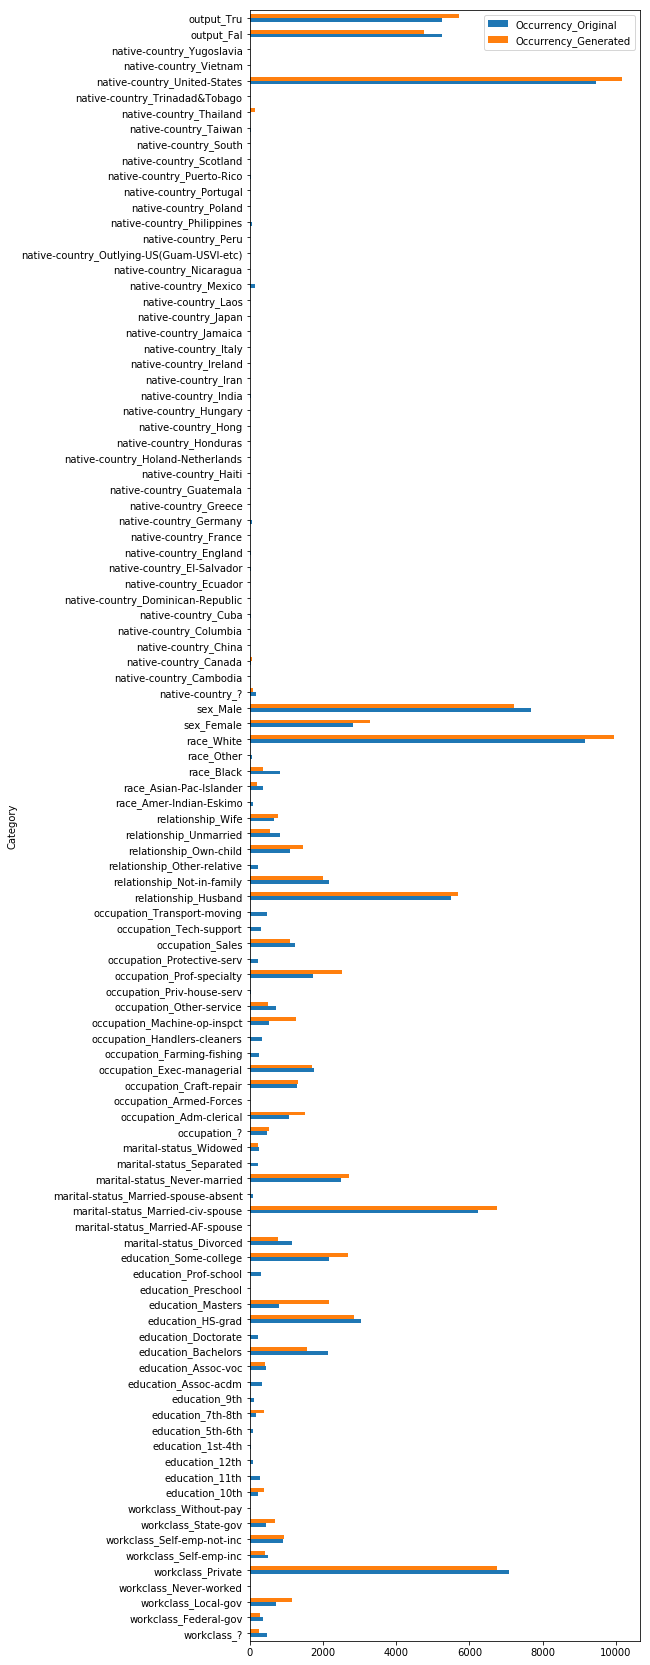

In [ ]:
%matplotlib inline

df.plot(kind='barh', figsize=(7,30))
plt.show()

In [ ]:
acc_test = pd.read_csv('./adult_test_stop_criterion/scores/accuracy_test.txt', header =None)
acc_train = pd.read_csv('./adult_test_stop_criterion/scores/accuracy_train.txt', header =None)
acc_test.columns = ['acc_test']
acc_train.columns = ['acc_train']

In [ ]:
epsilon=pd.read_csv('./adult_test_stop_criterion/scores/epsilon.txt',header =None)
epsilon.columns=['epsilon']

In [ ]:
df = acc_test.join(acc_train)
df.head()

,acc_test,acc_train
0,0.497999,0.503091
1,0.346894,0.501546
2,0.537062,0.499227
3,0.444550,0.505796
4,0.957127,0.418663


In [ ]:
df = df.join(epsilon)
df.head()

,acc_test,acc_train,epsilon
0,0.497999,0.503091,0.448825
1,0.346894,0.501546,0.745073
2,0.537062,0.499227,0.965266
3,0.444550,0.505796,1.145925
4,0.957127,0.418663,1.303305


In [ ]:
df.mean()

acc_test      0.719976
acc_train     0.698068
epsilon      17.188748
dtype: float64

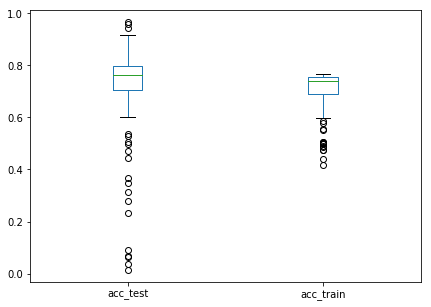

In [ ]:
%matplotlib inline
df.iloc[:,0:2].plot.box(figsize=(7,5))
plt.show()

In [ ]:
# acc_valid = 0.79
df['diversity'] = np.abs(0.79-df['acc_train'])
df['similarity'] = np.abs(0.79-df['acc_test'])

In [ ]:
df.head()

,acc_test,acc_train,epsilon,diversity,similarity
0,0.497999,0.503091,0.448825,0.286909,0.292001
1,0.346894,0.501546,0.745073,0.288454,0.443106
2,0.537062,0.499227,0.965266,0.290773,0.252938
3,0.444550,0.505796,1.145925,0.284204,0.345450
4,0.957127,0.418663,1.303305,0.371337,0.167127


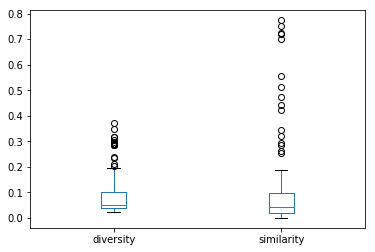

In [ ]:
df.iloc[:,3:5].plot.box()

plt.show()

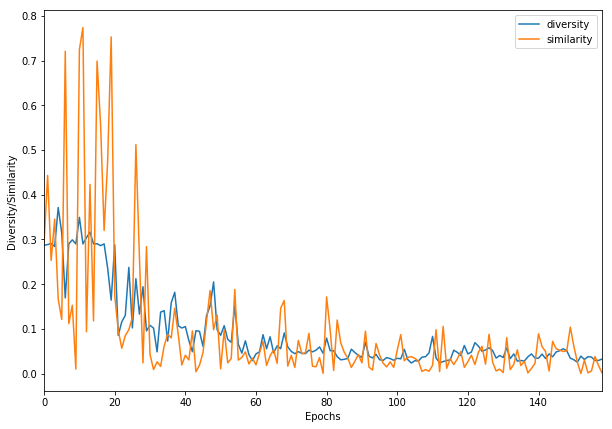

In [ ]:
df.iloc[:,3:5].plot(figsize=(10,7))
plt.ylabel('Diversity/Similarity')
plt.xlabel('Epochs')
plt.show()

Ideally, both measures,i.e. divesrity and similarity has to be = 0. The good ratio quality/utility of generated data was achieved after 50-60 epochs